# Random Forests

Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). We are dealing with classification trees and how to incorporate them into an ensemble (random forest)

Slides at http://www.cs.ubc.ca/~nando/540-2013/lectures/l9.pdf

In [1]:
%matplotlib inline
import graphviz as gv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

# path to png's
PATH = 'C:\\Users\\Egbert\\datascience\\ubc_ml\\tut_png\\random_forests\\'

Random forests are an ensemble learning method for classification, regression and other tasks operating by constructing a multitude of decision trees on a training set and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set. 

RFs, just like boosting, are **ensemble methods**. Assume we want to classify and we have a matrix of $d = 3$ features and $n=5$ (data). 

$\underbrace{\begin{bmatrix}
1 & 3  & 0 & 8  & 5       \\
0 & 6  & 2 & 9  & 5       \\
2 & 1  & 4 & 0  & 1       \\
            \end{bmatrix}
            }_{i= 1, i= 2, i =3, i= 4, i =5}
            \hspace{2mm}
y = [0,1,0,1,0]$ 

where $y$ is a classification label (f.i. classes/sex etc). If we want to construct a tree and inject randomness we could do the following: pick 2 features at random, say $X_{j} =1$ and $X_{j}=3$. Next step depends on your implementation of your RF but basically projects those points on each axis and these coordinates would be your splitpoints (5 x-points, 5 y-points) that can split your node into 10 children:

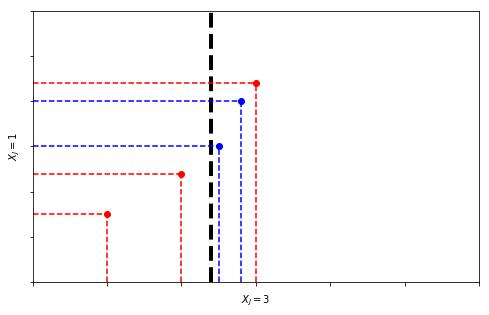

In [29]:
values_red =[[1,1.5],[2,2.4],[3,4.4]]
values_blue =[[2.5,3],[2.8,4]]

fig, ax = plt.subplots(figsize =[8,5])
ax.plot(*zip(*values_red), marker='o', color='r', ls='')
ax.plot(*zip(*values_blue), marker='o', color='blue', ls='')
ax.vlines(2.4, 0, 6, linestyle= '--', lw=4)

for v in values_red:
    ax.plot([v[0], v[0]], [0, v[1]], linestyle = '--', color='red')
    ax.plot([0, v[0]], [v[1], v[1]] ,linestyle = '--', color='red')

for v in values_blue:
    ax.plot([v[0], v[0]], [0, v[1]], linestyle = '--', color='blue')
    ax.plot([0, v[0]], [v[1], v[1]] ,linestyle = '--', color='blue')

ax.set(xlabel = '$X_{J}=3$', ylabel = '$X_{J}=1$', xticklabels =[], yticklabels=[])
ax.axis([0,6, 0,6]);

For each split point I evaluate the Information Gain (IG), using the formula of Entropy and choose the one with the highest IG. Most likely the split point will lay somewhere very close to the dotted black line. Hence my tree is doing the following:

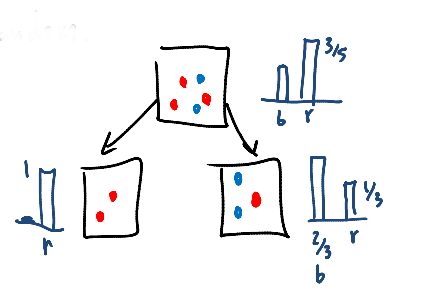

In [49]:
Image(PATH + 'tree_split.png')

By randomly selecting a subset, we only need to evaluate the split points for just a few points. If your data is very large with many dimensions w/o this random subsetting your IG calculations will become very computationally expensive. You repeat this process for the other nodes as well. It can turn out that you tree will not be a very good classifier but that, by combining many trees, we can get very good results. The random forest algorythm goes like this:

-1) For $b=1$ to $B$ (where B are the trees)
   - (a) Draw a bootstrap (bagging) sample $\mathcal{Z}$ of size $N$ from the training data.
   - (b) Grow a random-forest tree $T_{b}$ to the bootstrapped data, by recursively repeating the follwoing steps for each terminal node of the tree, until the minimum node size $n_{min}$ is reached
       - i.   Select $m$ variables at random from the $p$ variables
       - ii.  Pick the best variable/split-point among the $m$
       - iii. Split the node into 2 daughter nodes
       
-2) Output the ensemble of tree $\{T_{b}\}^{B}_{1}$

*source [From the book of Hastie, Friedman and Tibshirani]* 

This can be completely scaled by dividing trees on machines. 

The algorithm has 2 sources of randomness: in the data (so every tree will see a different dataset --> we take N data with replacement and we draw n data points uniformly at random = bootstrap) in the splits. We use different datasets to train different classifiers. 

If you construct each tree on different random subsets of the data, the process is called **bagging**
Bagging is an approach to ensemble learning that is based on bootstrapping. Shortly, given a training set, we produce multiple different training sets (called bootstrap samples), by sampling with replacement from the original dataset. Then, for each bootstrap sample, we build a model. The results in an ensemble of models, where each model votes with the equal weight. Typically, the goal of this procedure is to reduce the variance of the model of interest (e.g. decision trees).

**Bootstrapping** is a more generic statistical technique to approximate the sampling distribution, that in one way or another uses resampling with replacement.

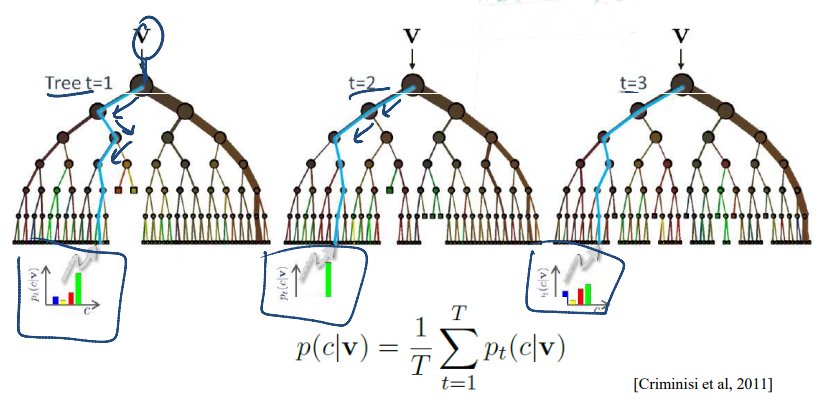

In [50]:
Image(PATH + 'buidling_forests.png')

The idea of averaging estimators is what we call bagging. What are we averaging actually? Suppose we have 3 trees in our ensemble. Each tree is different because we trained it on different subsets of the data and features were chosen randomly. When we get a point in the test data (new point $V$), it'll go into the trees and follow the decisions. when it arrives at the leaf, we'll have different class probabilities. Averaging means you take the histograms (4 vectors of 3 entries in this case that add up to 1), sum them up and divide by 3. 

$p(c \rvert V) = \frac{1}{T} \sum^{T}_{t=1}p_{t}(c \rvert V)$

where c is the color in this case.

Last note for completeness purposes: Randomized node optimization: if T is the entire dataset of all possible parameters $\theta$ (maning all the possible thresholds), then when training the $j_{th}$ node, we only make available a small subset $T_{j}CT$

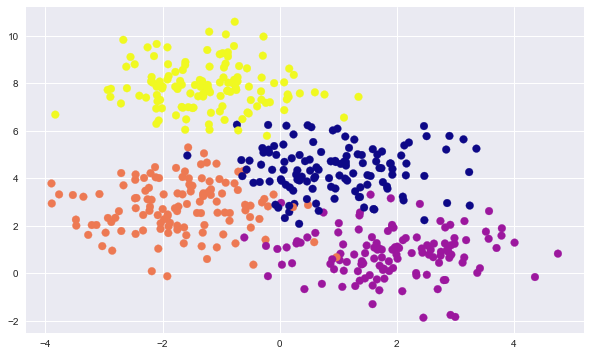

In [115]:
# mock example to see RF in action
from sklearn.datasets import make_blobs
fig, ax = plt.subplots(figsize = [10,6])
X, y = make_blobs(n_samples=500, centers = 4, random_state=0, cluster_std=1)
ax.scatter(X[:,0], X[:, 1], c=y, s=60, cmap='plasma');

In [121]:
# fit a Random forest to the ficticious blob data
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier().fit(X, y)

In [127]:
def viz_rf(model, X, y, cmap = 'plasma'):
    # Plot training points
    fig, ax = plt.subplots(figsize=[10,6])
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)

    # fit 
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = random_forest.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # plot
    n_classes = len(np.unique(y))
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, 
                clim=(y.min(), y.max()), zorder=1)

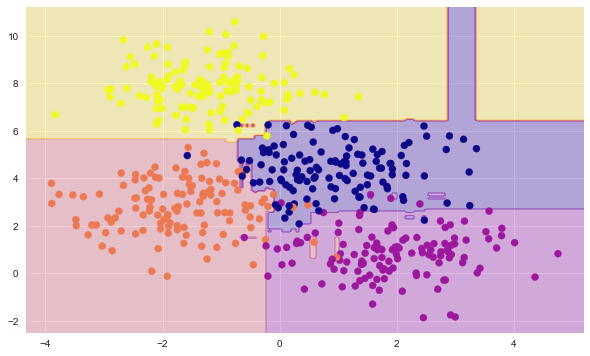

In [126]:
viz_rf(random_forest, X, y)

Decision trees in general tend to **overfit**: we can go deep in the tree, and therefore to fit details of the particular training data rather than the overall properties of the distributions they are drawn from. They will generally produce bad result on unseen test data. The notion of multiple overfitting estimators that can be combined to reduce the overfitting effect is what ensemble methods are all about based on the **bagging principle**. Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. 

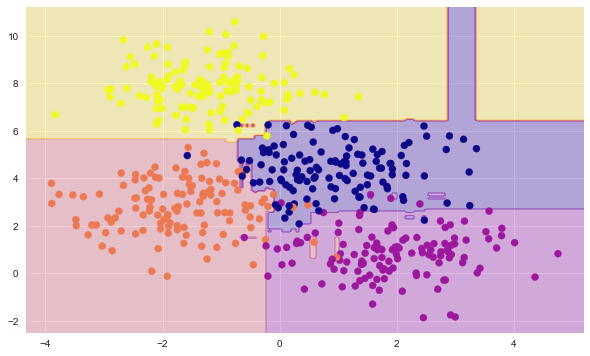

In [132]:
random_forest2 = RandomForestClassifier(n_estimators=150, random_state=0)
viz_rf(random_forest2, X, y)

The above visualization shows that by averaging +150 randomly generated models, the overall model is closer to our intuition about how the parameter space should be split. Powerful stuff.


Overall advantages of RFs:
- Both training + prediction are very fast, due to the simple structure of the decision trees. 
- Can be easily scaled: the tress are independent and can be divided over several clusters.
- Possibility to use probabilities: a majority vote among estimators gives an estimate of the probability (via predict_proba() method). See the Majority vote code in action at: https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch07/ch07.ipynb from the excellent book 'Python Machine Learning'

### Random Forests for text classification

In news categorization, a possible term is 'Obama'. A corresponding weak learner (node) is: if the term ' Obama' appears in the document, predict that the document belongs to the 'news' category. Now assume we have a list of 2 Million terms/words from the English language. We choose a random subset of say 50 words and we assume we have labels indicating a word is labeled 'spam', 'no-spam'. Then, we check in an e-mail message if the 50 randomly chosen words are resent or not. The appearance of a word like 'viagra' in the mail would split that document into 2 subsets. If we construct many trees in this fashion, average the results, we can use it as a text classifier. 40 out of 50 will be rejected and aren't good words we would use. At the end of the day the number of words deciding whether or not the mail is spam is the number of nodes in the tree. 

So originally we had a large 2Mio feature-set but in in order to learn, we only need a relatively small number of features. **Point is that RFs cannot only be used as a classifier but also as a feature ranking/selection method!**

### some add-ups:
- Effect of the tree-depth: if you build a tree that is very shallow, say 3 levels deep, we will tend to underfit and the decision boundaries will be harsh/coarse. Trees that are too deep, will tend to overfit because the decision boundaries look at too much detail. The separator is then unlikely to separate any new test point.

It's basically about complexity control, like with Cross Validation (CV). We have a lot of choices with Random Forests, a lot of parameters to tune that can be optimized with Bayesian Optimization applied on top of the tree --> all these choices are just random parameters but by applying Gaussian Processes and Bayesian Optimization, we define a GP over al the choices, pick 1 parameter and then establish how well the tree performs using CV and that will give you the error for Bayesian Optimization. CV and building trees are expensive operations, that's why you would balance Exploration vs Exploitation. 

# Random Forest for regression

Since the target variable is a continuous real number, we fit a regression model to the target variable using each of the independent variables. Then for each of these, the data is split at several splitpoints and we calculate the sum of squared error (SSE) at each soplit point between the predicted value and the actual values. The variable resulting in a minimum SSE is selected for the node. 

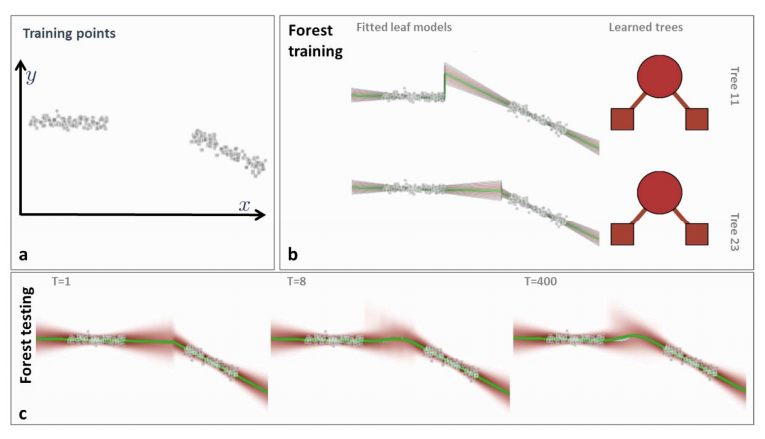

In [78]:
Image(PATH + 'regression_forests.png') # Criminisi et al, 2011

Region $T=1$ (or leaf), and all the other regions, we'll want to minimize the $\underset{i \mathcal{E}T}{\sum} (\hat{y}-y_{i})^{2}$ in each leaf where $i$ are all the indices of the points that lie in the region f.i $T=1$

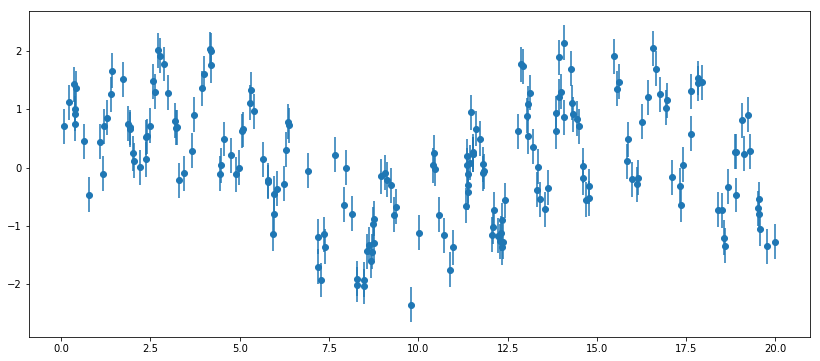

In [67]:
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

fig, ax  = plt.subplots(figsize=[14,6])
rng = np.random.RandomState(0)
x = 20 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
ax.errorbar(x, y, 0.3, fmt='o');

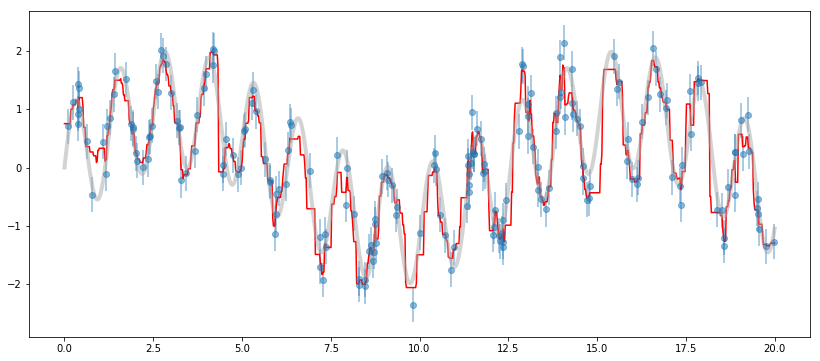

In [68]:
from sklearn.ensemble import RandomForestRegressor

fig, ax  = plt.subplots(figsize=[14,6])
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(x[:, None], y)

xfit = np.linspace(0, 20, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

ax.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
ax.plot(xfit, yfit, '-r');
ax.plot(xfit, ytrue, color = 'darkgray', lw = 4, linestyle = '-', alpha=0.5);

### Case: red wine. 

From the site 'http://mlr.cs.umass.edu/ml/machine-learning-databases/' we can download and use multiple datasets suitable for ML practise. 

The wine quality dataset at http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/ has a csv set containing features on wine like 'fixed acidity', 'volatile acidity', 'citric acid', 'residual', 'sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol' in order to predict the wine quality (array([3, 4, 5, 6, 7, 8])

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Load red wine data.
url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wine = pd.read_csv(dataset_url, sep=';')

In [50]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [77]:
y = wine['quality'] # target variable
X = wine.iloc[:,:11] # feature variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# model
rfr = RandomForestRegressor(n_estimators=100)
pipeline = make_pipeline(StandardScaler(), rfr)
 
# parameters for GridSearch
hyperparameters = {'randomforestregressor__max_features' : ['auto', 'log2', 6],
                   'randomforestregressor__max_depth': [None, 6, 5, 3]}
 
# Grid search + CV 
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(X_train, y_train)
 
# score test data
pred = clf.predict(X_test)
print ('MSE: {}'.format(mean_squared_error(y_test, pred)))

MSE: 0.3398515151515152


In [81]:
print ('Best parameters that the GridSearch selected: {}' .format(clf.best_params_))

Best parameters that the GridSearch selected: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'log2'}
